# Анализ эксперимента лендинга Сбермаркета
**Задание аналитика в [Карьерный цех](https://analytics.careerfactory.ru/)**

## Описание

На текущем варианте лендинга пользователь сначала выбирает ритейлера, переходит в каталог, ищет нужные ему товары и только потом может узнать, что по его адресу выбранного магазина может не оказаться. Проведён эксперимент (A/B тестирование) с двумя вариантами лендинга.

**Исходные данные:**

Данные состоят из файлов, полученных из разных источников:

- `AB Test Hit.csv` — пользователи и распределение по группам эксперимента;
- `Landing Viewed.csv` — время захода пользователя на лэндинг;
- `Main Page Viewed.csv` — время захода на страницу ретейлера;
- `Address Change Initiated.csv` — время открытия модалки ввода адреса;
- `Address Not In Delivery Zone.csv` — время получения сообщения "Адрес вне зоны доставки";
- `Shop Celection Started.csv` — время открытия модалки выбора магазина;
- `Shop Selected.csv` — время успешного выбора магазина;
- `Product Added.csv` — время фактического добавления товара в корзину;
- `Add To Cart Clicked.csv` — время попытки (клика) добавления товара в корзину;
- `Order Completed.csv` — время оформления заказа.

**Цели:**
- проанализировать дизайн эксперимента и предложить идеи для улучшения. Необходимо проверить гипотезу, что выбор адреса до этапа выбора магазина поможет избежать “кривых” сценариев без повышения отказов с самого лендинга;
- по метрикам bounce rate лендинга (в тестовых группах он не должен стат значимо вырасти) и конверсии добавления товара в корзину принять решение какой вариант лендинга лучше.

_bounce rate - это термин веб-аналитики, обозначающий процентное соотношение количества посетителей покинувших сайт или лендинг прямо со страницы входа или просмотревших не более одной страницы сайта._

### Структура проекта
* [1. Загрузка и изучение общей информации датасета](#start)
* [2. Предобработка данных](#preprocessing)
* [3. Исследовательский анализ данных](#eda)
* [4. Расчёт метрик (bounce rate лендинга и конверсию)](#metric)
* [5. Диагностика дизайна эксперимента](#experiment)
* [6. Выводы](#conclusion)

<a id="start"></a>
## 1. Загрузка и изучение общей информации датасета

### Импортируем необходимые библиотеки

In [1]:
import re
import math
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

Pandas version: 1.2.4
Seaborn version: 0.11.1


### Загрузим данные

In [2]:
# input path of datasets
PATH = input()

./dataset/


In [3]:
list_df = []
dataset_ab_test  = 'AB Test Hit.csv'
dataset_landing = 'Landing Viewed.csv'
dataset_mainpage = 'Main Page Viewed.csv'
dataset_address_change = 'Address Change Initiated.csv'
dataset_delivery_zone = 'Address Not In Delivery Zone.csv'
dataset_shop_started = 'Shop Celection Started.csv'
dataset_shop_selected = 'Shop Selected.csv'
dataset_product = 'Product Added.csv'
dataset_cart = 'Add To Cart Clicked.csv'
dataset_order = 'Order Completed.csv'

try:
    df_ab_test = pd.read_csv(f'{PATH}{dataset_ab_test}', sep=',')
    df_landing = pd.read_csv(f'{PATH}{dataset_landing}', sep=',')
    df_mainpage = pd.read_csv(f'{PATH}{dataset_mainpage}', sep=',')
    df_address_change = pd.read_csv(f'{PATH}{dataset_address_change}', sep=',')
    df_delivery_zone = pd.read_csv(f'{PATH}{dataset_delivery_zone}', sep=',')
    df_shop_started = pd.read_csv(f'{PATH}{dataset_shop_started}', sep=',')
    df_shop_selected = pd.read_csv(f'{PATH}{dataset_shop_selected}', sep=',')
    df_product = pd.read_csv(f'{PATH}{dataset_product}', sep=',')
    df_cart = pd.read_csv(f'{PATH}{dataset_cart}', sep=',')
    df_order = pd.read_csv(f'{PATH}{dataset_order}', sep=',')
    print('Dataset has successfully read')
    list_df.extend([df_ab_test, df_landing, df_mainpage, df_address_change, df_delivery_zone,
                    df_shop_started, df_shop_selected, df_product, df_cart, df_order])
except Exception as err:
    print(err)

Dataset has successfully read


In [4]:
df_descriptions = {
    'df_ab_test': 'AB Test Hit',
    'df_landing': 'Landing Viewed',
    'df_mainpage':'Main Page Viewed',
    'df_address_change': 'Address Change Initiated',
    'df_delivery_zone': 'Address Not In Delivery Zone',
    'df_shop_started': 'Shop Celection Started',
    'df_shop_selected': 'Shop Selected',
    'df_product': 'Product Added',
    'df_cart': 'Add To Cart Clicked',
    'df_order': 'Order Completed'
}

# Get name of dataframe
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
for _df in list_df:
    print(get_df_name(_df))
    display(_df.info())

df_ab_test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502784 entries, 0 to 502783
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   hit_at        502784 non-null  object
 1   anonymous_id  502784 non-null  object
 2   group         502784 non-null  object
 3   device_type   502784 non-null  object
 4   browser       502784 non-null  object
 5   os            502783 non-null  object
dtypes: object(6)
memory usage: 23.0+ MB


None

df_landing
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341481 entries, 0 to 341480
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     341481 non-null  object
 1   anonymous_id  341481 non-null  object
dtypes: object(2)
memory usage: 5.2+ MB


None

df_mainpage
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613509 entries, 0 to 613508
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     613509 non-null  object
 1   anonymous_id  613509 non-null  object
 2   retailer_id   613509 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 14.0+ MB


None

df_address_change
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103434 entries, 0 to 103433
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     103434 non-null  object
 1   anonymous_id  103434 non-null  object
 2   source        103434 non-null  object
dtypes: object(3)
memory usage: 2.4+ MB


None

df_delivery_zone
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6167 entries, 0 to 6166
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     6167 non-null   object
 1   anonymous_id  6167 non-null   object
dtypes: object(2)
memory usage: 96.5+ KB


None

df_shop_started
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57407 entries, 0 to 57406
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   timestamp     57407 non-null  object
 1   anonymous_id  57407 non-null  object
 2   source        57407 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


None

df_shop_selected
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211728 entries, 0 to 211727
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   timestamp     211728 non-null  object
 1   anonymous_id  211728 non-null  object
 2   source        211728 non-null  object
dtypes: object(3)
memory usage: 4.8+ MB


None

df_product
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150060 entries, 0 to 1150059
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   timestamp     1150060 non-null  object
 1   anonymous_id  1150060 non-null  object
dtypes: object(2)
memory usage: 17.5+ MB


None

df_cart
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1223417 entries, 0 to 1223416
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   timestamp     1223417 non-null  object
 1   anonymous_id  1223417 non-null  object
dtypes: object(2)
memory usage: 18.7+ MB


None

df_order
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16650 entries, 0 to 16649
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     16650 non-null  object 
 1   anonymous_id  16650 non-null  object 
 2   order_sum     16650 non-null  float64
dtypes: float64(1), object(2)
memory usage: 390.4+ KB


None

Выявили 1 пропуск в типе ОС пользователя

In [6]:
df_ab_test.loc[df_ab_test.isna().any(axis=1),:]

,hit_at,anonymous_id,group,device_type,browser,os
353476,2020-11-26 08:04:14.164 UTC,43c2bbe6-ba74-4b76-9597-421d3175ad30,default,desktop,Firefox,NaN


<a id="preprocessing"></a>
## 2. Предобработка данных

### Приведём дату к типу `datetime` во всех
И обрежем время до секунды

In [7]:
df_ab_test['hit_at'] = df_ab_test['hit_at'].apply(lambda x: re.sub(r"\.[0-9]{1,3}", "", x))
df_ab_test['hit_at'] = pd.to_datetime(df_ab_test['hit_at'], format='%Y-%m-%d %H:%M:%S %Z')

In [8]:
for _df in list_df:
    if _df.equals(df_ab_test):
        continue
    _df['timestamp'] = _df['timestamp'].apply(lambda x: re.sub(r"\.[0-9]{1,3}", "", x))
    _df['timestamp'] = pd.to_datetime(_df['timestamp'], format='%Y-%m-%d %H:%M:%S %Z')

### Удалим все полные дубликаты во всех таблицах

Неопытный аналитик мог совершить ошибку в сборе данных и задублировать их

In [9]:
for i, _df in enumerate(list_df):
    df_name = get_df_name(_df)
    n_duplicates = _df[_df.duplicated(keep='first')].shape[0]
    list_df[i] = list_df[i].drop_duplicates()
    print(f"{n_duplicates} rows duplicated has removed in {df_name} table")

# Prevent copy of dataframes
df_ab_test = list_df[0]
df_landing = list_df[1]
df_mainpage = list_df[2]
df_adress_change = list_df[3]
df_delivery_zone = list_df[4]
df_shop_started = list_df[5]
df_shop_selected = list_df[6]
df_product = list_df[7]
df_cart = list_df[8]
df_order = list_df[9]

124 rows duplicated has removed in df_ab_test table
2324 rows duplicated has removed in df_landing table
7932 rows duplicated has removed in df_mainpage table
920 rows duplicated has removed in df_address_change table
3 rows duplicated has removed in df_delivery_zone table
562 rows duplicated has removed in df_shop_started table
22348 rows duplicated has removed in df_shop_selected table
4400 rows duplicated has removed in df_product table
4400 rows duplicated has removed in df_cart table
0 rows duplicated has removed in df_order table


<a id="eda"></a>
## 3. Исследовательский анализ данных

### Оставим только тех пользователей которые были на странице лендинга

Оставим только первый заход на лендинг для каждого пользователя

In [10]:
df_landing = df_landing.sort_values('timestamp').drop_duplicates('anonymous_id')

In [11]:
df = df_ab_test.copy().merge(df_landing, how='left', on='anonymous_id')
#df = df.groupby(['anonymous_id'])['timestamp'].min().reset_index() # keep only first visit of landing

df = df.rename(columns={"timestamp": "timestamp_landing"})
df_nan = df['timestamp_landing'].isna()

print(f"{df_nan.sum()}({(df_nan.sum()/df.shape[0])*100:.2f}%) rows of clients not viewed landing has removed")

df = df[~df_nan]

282744(56.25%) rows of clients not viewed landing has removed


Удалили **56%** записей по пользователями которые не бывали на лендинге. Это очень большая доля от всех пользователей.

### Если пользователь несколько раз попал в группу A/B тестирования то оставим только одну запись

#### Оставим только первую по времени запись

In [12]:
first_unique_id = df[['hit_at', 'anonymous_id']].groupby('anonymous_id').min()
df = first_unique_id.reset_index().merge(df, how='left', on=['anonymous_id', 'hit_at'])

#### Не будем учитывать пользователей которые попали в обе группы

Проверим есть ли дублирование пользователей по группам

In [13]:
group_doubles = df.duplicated(subset=['anonymous_id', 'hit_at', 'device_type', 'browser', 'os'], keep=False)

Удалим дубликаты

In [14]:
df = df[~group_doubles]

Проверим, что у нас осталось только по 1 записи на уникального пользователя

In [15]:
df[df.duplicated(subset='anonymous_id', keep=False)].shape[0]

0

### Временные характеристики эксперимента

In [16]:
print(f"Начало эксперимента: {df_ab_test['hit_at'].min()}")
print(f"Конец эксперимента: {df_ab_test['hit_at'].max()}")
print(f"Продолжительность эксперимента: {(df_ab_test['hit_at'].max() - df_ab_test['hit_at'].min())}")

Начало эксперимента: 2020-11-26 00:00:10+00:00
Конец эксперимента: 2020-12-10 23:59:57+00:00
Продолжительность эксперимента: 14 days 23:59:47


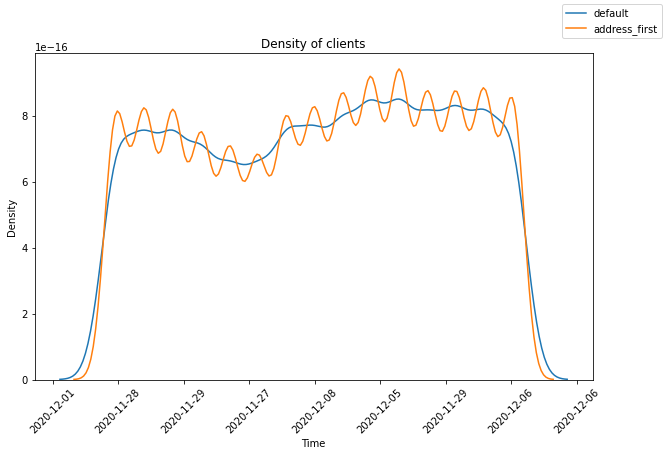

In [17]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10,6))
graph = df_ab_test.groupby('group')['hit_at'].apply(lambda x: sns.distplot(x, hist=False, rug=False, label='time'))
graph.iloc[0].set_xticklabels(labels=df_ab_test['hit_at'].dt.strftime('%Y-%m-%d'), rotation=45)
graph.iloc[0].set(xlabel='Time')

fig.legend(labels=['default','address_first'])
plt.title('Density of clients')
plt.show()

Можем сделать вывод, что число пользователей каждый день было примерно одинаково независимо от группы относительно общего числа пользователей группы. Скачки в числе показов лендинга с адресом требуют дополнительного исследования.

### Cоотношение распределение пользователей в A/B тестировании

In [18]:
def percentage_string(x):
    '''Return percent as string'''
    if x > 0.01 or math.isclose(x, 0):
        return f"{round(x,2)*100:.0f}%"
    else:
        return "<1%"

In [19]:
COLORS = ['Red','Orange', 'Blue', 'Purple', 'Green', 'Magenta']

In [20]:
def plot_bar(data, column='count', title=None):
    plt.figure(figsize=(len(data.index)*1.5,5))
    graph = plt.bar(data.index, data[column], color=COLORS)

    plt.title(title)

    for p, i in zip(graph, range(len(graph))):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        plt.text(x+width/2,
                 y+height*.5,
                 data.percent[i],
                 ha='center')
    plt.show()

#### Посмотрим соотношение распределение пользователей по группам A/B тестирования

In [21]:
groups_count = df[['anonymous_id', 'group']].groupby('group').agg(['size'])
groups_count.columns = ['count']
groups_count['percent'] = groups_count.transform(lambda x: x/x.sum())
groups_count['percent'] = groups_count['percent'].transform(percentage_string)

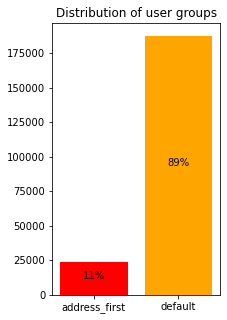

In [22]:
plot_bar(groups_count, title='Distribution of user groups')

Наблюдаем, что распределение пользователей по группам которым показывался разный вариант лендинга сильно несбалансировано.

#### Посмотрим с каким платформ заходили на лендинг

In [23]:
pd.pivot_table(df, values='anonymous_id', index=['group', 'device_type'], aggfunc='count')

anonymous_id
group         device_type              
address_first console                 1
              desktop             11246
              mobile              11993
              smarttv                 1
              tablet                358
default       console                 8
              desktop             90428
              mobile              94111
              smarttv                 7
              tablet               2705

Кол-во пользователей с консолей и смартТВ незначительное. Отметим, что число пользователей с планшета невелико.

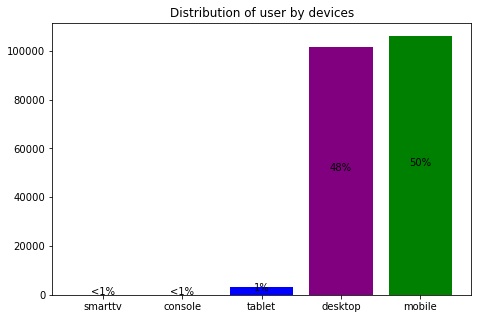

In [24]:
device_count = df[['anonymous_id', 'device_type']].groupby('device_type').agg(['size'])
device_count.columns = ['count']
device_count['percent'] = device_count.transform(lambda x: x/x.sum())
device_count['percent'] = device_count['percent'].transform(percentage_string)
device_count = device_count.sort_values('count')

plot_bar(device_count, title='Distribution of user by devices')

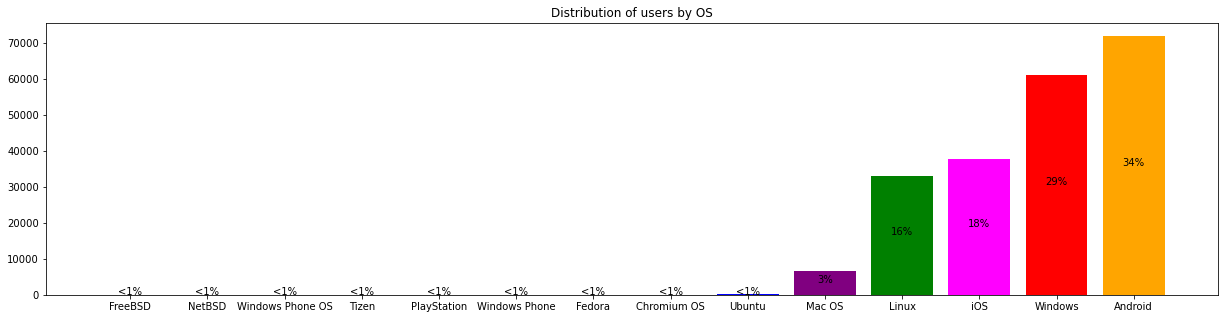

In [25]:
os_count = df[['anonymous_id', 'os']].groupby('os').agg(['size'])
os_count.columns = ['count']
os_count['percent'] = os_count.transform(lambda x: x/x.sum())
os_count['percent'] = os_count['percent'].transform(percentage_string)
os_count = os_count.sort_values('count')

plot_bar(os_count, title='Distribution of users by OS')

In [26]:
browser_count = df_ab_test[['anonymous_id', 'browser']].groupby('browser').agg(['size'])
browser_count.columns = ['count']
browser_count['percent'] = browser_count.transform(lambda x: x/x.sum())
browser_count['percent'] = browser_count['percent'].transform(percentage_string)
browser_count = browser_count.sort_values('count')

browser_count.sort_values('count', ascending=False)

,count,percent
browser,,
Chrome,250166,50%
Mobile Safari,83765,17%
Yandex,53589,11%
Chrome WebView,18897,4%
WebKit,18045,4%
Samsung Browser,16020,3%
Firefox,15088,3%
Opera,12907,3%
MIUI Browser,12526,2%


Половина всех пользователей среди большого количества браузеров используют Google Chrome

<a id="metric"></a>
## 4. Расчёт метрик (bounce rate лендинга и конверсию)

### Рассчитаем конверсию добавления товара в корзину

In [27]:
df_product = df_product.sort_values('timestamp').drop_duplicates('anonymous_id')

In [28]:
df = df.merge(df_product, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_added_cart"})

#### Рассчитаем сколько времени потребовалось между просмотром лендинга и добавлением товара в корзину

In [29]:
df['time_to_cart_add'] = df['timestamp_added_cart'] - df['timestamp_landing']

Удалим записи в которых добавление в корзину позже просмотра лендинга

In [30]:
df = df[~(df['time_to_cart_add'] < pd.Timedelta(0))]

#### Проверим конверсию по группам A/B тестирования

In [31]:
t1 = pd.pivot_table(df, values='timestamp_added_cart', index=['group'], aggfunc='count')
t1.columns=['count_cart']
t2 = pd.pivot_table(df, values='anonymous_id', index=['group'], aggfunc='count')
t2.columns=['count_landing']
df_conversion = pd.concat([t1, t2], axis=1)
df_conversion['conversion'] = df_conversion['count_cart'].values / df_conversion['count_landing'].values
df_conversion['conversion_%'] = df_conversion['conversion'].transform(percentage_string)
df_conversion

,count_cart,count_landing,conversion,conversion_%
group,,,,
address_first,3516,23234,0.151330,15%
default,23737,184510,0.128649,13%


**По всем пользователям конверсия с новым лендингом выше на 2% (15% и 13%)**

При значении статистической значимости в 0.05 с высокой вероятностью конверсия нового лендинга выше, чем старого (p < 0.001)

<img src="pics/conversion_significance.png">

#### Проверим конверсию по типам устройств используемых пользователями

In [32]:
t1 = pd.pivot_table(df, values='timestamp_added_cart', index=['group', 'device_type'], aggfunc='count')
t1.columns=['count_cart']
t2 = pd.pivot_table(df, values='anonymous_id', index=['group', 'device_type'], aggfunc='count')
t2.columns=['count_landing']
df_conversion = pd.concat([t1, t2], axis=1)
df_conversion['conversion'] = df_conversion['count_cart'].values / df_conversion['count_landing'].values
df_conversion['conversion_%'] = df_conversion['conversion'].transform(percentage_string)
df_conversion

count_cart  count_landing  conversion conversion_%
group         device_type                                                    
address_first console               0              1    0.000000           0%
              desktop            2345          10936    0.214429          21%
              mobile             1135          11946    0.095011          10%
              smarttv               0              1    0.000000           0%
              tablet               36            350    0.102857          10%
default       console               0              8    0.000000           0%
              desktop           17593          88133    0.199619          20%
              mobile             5903          93694    0.063003           6%
              smarttv               2              7    0.285714          29%
              tablet              239           2668    0.089580           9%

**Конверсия между группами пользователей среди пользователей с мобильных устройств отличается на 4% или в ~1.5 раза (10% и 6%)**


<img src="pics/conversion_mobile_significance.png">

**Конверсия между группами пользователей среди пользователей с ПК 21.4% и 20%**


<img src="pics/conversion_desktop_significance.png">

По каким-то причинам ни один пользователь с консоли не добавил товар в корзину. И в группе пользователей `address_first` ни один пользователь не добавил товар в корзину, поэтому всех пользователей которые зашли на лендинг с консоли и смартТВ.

Необходимо провести дополнительное расследование нет ли ошибки в лендинге которая не позволяет дойти до добавления товара в корзину при использовании смартТВ или консоли. Нужно учитывать незначительное число пользователей с этих типов устройств.

#### Проверим конверсию по типам ОС

In [33]:
t1 = pd.pivot_table(df, values='timestamp_added_cart', index=['group', 'os'], aggfunc='count')
t1.columns=['count_cart']
t2 = pd.pivot_table(df, values='anonymous_id', index=['group', 'os'], aggfunc='count')
t2.columns=['count_landing']
df_conversion = pd.concat([t1, t2], axis=1)
df_conversion['conversion'] = df_conversion['count_cart'].values / df_conversion['count_landing'].values
df_conversion['conversion_%'] = df_conversion['conversion'].transform(percentage_string)
df_conversion

count_cart  count_landing  conversion  \
group         os                                                        
address_first Android                  779           8050    0.096770   
              Chromium OS                1              4    0.250000   
              Fedora                     0              4    0.000000   
              Linux                     20           3637    0.005499   
              Mac OS                   229            711    0.322082   
              PlayStation                0              1    0.000000   
              Tizen                      0              1    0.000000   
              Ubuntu                     5             32    0.156250   
              Windows                 2081           6497    0.320302   
              Windows Phone              0              1    0.000000   
              Windows Phone OS           0              1    0.000000   
              iOS                      401           4295    0.093364   
default       Android                 4053          63555    0.063772   
              Chromium OS                2             20    0.100000   
              Fedora                     3              8    0.375000   
              FreeBSD                    0              1    0.000000   
              Linux                    217          29502    0.007355   
              Mac OS                  1970           5806    0.339304   
              NetBSD                     0              1    0.000000   
              PlayStation                0              8    0.000000   
              Tizen                      2              6    0.333333   
              Ubuntu                    48            216    0.222222   
              Windows                15311          52168    0.293494   
              Windows Phone              0             12    0.000000   
              iOS                     2131          33206    0.064175   

                               conversion_%  
group         os                             
address_first Android                   10%  
              Chromium OS               25%  
              Fedora                     0%  
              Linux                     <1%  
              Mac OS                    32%  
              PlayStation                0%  
              Tizen                      0%  
              Ubuntu                    16%  
              Windows                   32%  
              Windows Phone              0%  
              Windows Phone OS           0%  
              iOS                        9%  
default       Android                    6%  
              Chromium OS               10%  
              Fedora                    38%  
              FreeBSD                    0%  
              Linux                     <1%  
              Mac OS                    34%  
              NetBSD                     0%  
              PlayStation                0%  
              Tizen                     33%  
              Ubuntu                    22%  
              Windows                   29%  
              Windows Phone              0%  
              iOS                        6%

### Рассчитаем bounce rate лендинга

Для расчёта bounce rate лендинга необходимо рассчитать перешёл ли пользователь с лендинга на следующую страницу (для каждой группы это разная страница)

In [34]:
df_mainpage = df_mainpage.sort_values('timestamp').drop_duplicates('anonymous_id')
df_adress_change = df_adress_change.sort_values('timestamp').drop_duplicates('anonymous_id')
df_delivery_zone = df_delivery_zone.sort_values('timestamp').drop_duplicates('anonymous_id')
df_shop_started = df_shop_started.sort_values('timestamp').drop_duplicates('anonymous_id')
df_shop_selected = df_shop_selected.sort_values('timestamp').drop_duplicates('anonymous_id')
df_cart = df_cart.sort_values('timestamp').drop_duplicates('anonymous_id')
df_order = df_order.sort_values('timestamp').drop_duplicates('anonymous_id')

In [35]:
df = df.merge(df_mainpage, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_mainpage"})

df = df.merge(df_adress_change, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_address"})

df = df.merge(df_delivery_zone, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_delivery"})

df = df.merge(df_shop_started, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_shop_started"})

df = df.merge(df_shop_selected, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_shop_selected"})

df = df.merge(df_cart, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_cart"})

df = df.merge(df_order, how='left', on='anonymous_id')
df = df.rename(columns={"timestamp": "timestamp_order"})

In [36]:
df_default = df[df['group']=='default']
df_address = df[df['group']=='address_first']

In [37]:
t1 = pd.pivot_table(df_default, values='timestamp_mainpage', index=['group'], aggfunc='count')
t1.columns=['count_maipage']
t2 = pd.pivot_table(df_default, values='anonymous_id', index=['group'], aggfunc='count')
t2.columns=['count_landing']
df_bounce = pd.concat([t1, t2], axis=1)
df_bounce['rate'] = df_bounce['count_maipage'].values / df_bounce['count_landing'].values
df_bounce['rate_%'] = df_bounce['rate'].transform(percentage_string)
df_bounce

,count_maipage,count_landing,rate,rate_%
group,,,,
default,84127,184510,0.455948,46%


In [38]:
t1 = pd.pivot_table(df_address, values='timestamp_address', index=['group'], aggfunc='count')
t1.columns=['count_address']
t2 = pd.pivot_table(df_address, values='anonymous_id', index=['group'], aggfunc='count')
t2.columns=['count_landing']
df_bounce = pd.concat([t1, t2], axis=1)
df_bounce['rate'] = df_bounce['count_address'].values / df_bounce['count_landing'].values
df_bounce['rate_%'] = df_bounce['rate'].transform(percentage_string)
df_bounce

,count_address,count_landing,rate,rate_%
group,,,,
address_first,9165,23234,0.394465,39%


**Bounce rate дефолтного лендинга 46%, а лендинга с вводом адреса в начале 39%**

При значении статистической значимости в 0.05 с высокой вероятностью bounce rate нового лендинга ниже, чем старый (p < 0.001)
<img src="pics/bounce_rate_significance.png">

<a id="experiment"></a>
## 5. Диагностика дизайна эксперимента

В дизайне эксперимента не учтено, что пользователь зарегистрирован, уже ввёл адрес и не заходил на страницу лендинга.
Пользователей с уже введённым адресом необходимо не учитывать в эксперименте.

<a id="conclusion"></a>
## 6. Выводы

- выявлена аномалия в различии в числе заходов пользователей на лендинг в течении дня
- **56%** всех пользователей не бывали на странице лендинга
- группы A/B тестирования несбалансированы (89% `default` и 11% `address_first`)
- более **98%** пользователей использовали ПК или смартфон
- с высокой вероятностью конверсия нового лендинга выше, чем старого (**15.13%** и **12.86%** соответственно)
- с высокой вероятностью bounce rate нового лендинга ниже, чем старого (**39.44%** и **45.59%** соответственно)